Convert image to grayscale:

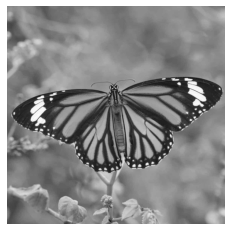

In [38]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

img = mpimg.imread('butterfly496.png')     
gray = rgb2gray(img)    
#plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
#plt.title("Original Image")
#plt.axis('off')
#plt.show()
fig = plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig('butterflygs496.png', bbox_inches='tight', pad_inches = 0)

In [3]:
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx

In [5]:
def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

# read original image and downsize for speed
Xorig = gray # read in grayscale
X = spimg.zoom(Xorig, 0.04)
ny,nx = X.shape

print(ny,nx)

47 47


In [28]:
# extract small sample of signal
k = round(nx * ny * 0.9) # 50% sample
ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
b = X.T.flat[ri]
b = np.expand_dims(b, axis=1)

# create dct matrix operator 
A = np.kron(
    spfft.idct(np.identity(nx), norm='ortho', axis=0),
    spfft.idct(np.identity(ny), norm='ortho', axis=0)
    )
A = A[ri,:] # same as phi times kron

# do L1 optimization
vx = cvx.Variable(shape=(nx*ny,1))
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A*vx == b]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)
Xat2 = np.array(vx.value).squeeze()

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Jul 04 01:06:30 AM: Your problem has 2209 variables, 1 constraints, and 0 parameters.
(CVXPY) Jul 04 01:06:30 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 04 01:06:30 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 04 01:06:30 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 04 01:06:30 AM: Compiling problem (target solver=ECOS).
(CVXPY) Jul 04 01:06:30 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

C:\Users\Janelle\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 6 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Jul 04 01:06:31 AM: Applying reduction ECOS
(CVXPY) Jul 04 01:06:33 AM: Finished problem compilation (took 2.853e+00 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jul 04 01:06:33 AM: Invoking solver ECOS  to obtain a solution.
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Jul 04 01:09:07 AM: Problem status: optimal
(CVXPY) Jul 04 01:09:07 AM: Optimal value: 2.550e+02
(CVXPY) Jul 04 01:09:07 AM: Compilation took 2.853e+00 seconds
(CVXPY) Jul 04 01:09:07 AM: Solver (including time spent in interface) took 1.543e+02 seconds


In [33]:
# reconstruct signal
Xat = Xat2.reshape(nx, ny).T 
Xa = idct2(Xat)

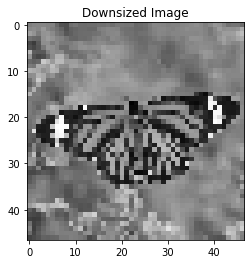

Text(0.5, 1.0, 'Reconstructed Image (90% sample)')

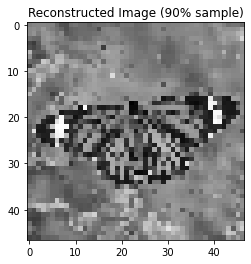

In [34]:
#Display the images
plt.imshow(X, cmap = 'gray')
plt.title("Downsized Image")
plt.show()
plt.imshow(Xa, cmap = 'gray')
plt.title("Reconstructed Image (90% sample)")



In [35]:
from skimage.metrics import structural_similarity as ssim
import cv2
import argparse

def mse(imageA, imageB):
 # the 'Mean Squared Error' between the two images is the sum of the squared difference between the two images
 mse_error = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
 mse_error /= float(imageA.shape[0] * imageA.shape[1])

 # return the MSE. The lower the error, the more "similar" the two images are.
 return mse_error

def compare(imageA, imageB):
 # Calculate the MSE and SSIM
 m = mse(imageA, imageB)
 s = ssim(imageA, imageB)

 # Return the SSIM. The higher the value, the more "similar" the two images are.
 return s


print(mse(X,Xa))
print(compare(X,Xa))

0.0028618502884983858
0.9083737991302884
